In [2]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import models, layers, optimizers, regularizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau
import librosa
import matplotlib.pyplot as plt

In [2]:
# Function to load and preprocess audio
def load_and_preprocess_audio(file_path, target_duration=3, target_sr=44100):
    # Load audio file with original sampling rate
    audio, sr = librosa.load(file_path, sr=None)

    # Resample if needed
    if sr != target_sr:
        audio = librosa.resample(y=audio, orig_sr=sr, target_sr=target_sr)
        sr = target_sr

    # Ensure target duration
    target_length = int(sr * target_duration)
    if len(audio) < target_length:
        audio = np.pad(audio, (0, target_length - len(audio)))
    elif len(audio) > target_length:
        audio = audio[:target_length]

    # Run the model, check the output
    embeddings = vggish_model(audio)
    embeddings.shape.assert_is_compatible_with([None, 128])
    return embeddings

In [3]:
# # Directory paths
audio_dir = os.path.join(os.path.expanduser("~"), "Desktop", "cse499b", "audio_mod")


In [3]:

# Load VGGish model from URL
vggish_model = hub.load('https://kaggle.com/models/google/vggish/frameworks/TensorFlow2/variations/vggish/versions/1')

In [5]:
# Feature extraction and data preparation
X_train = []
y_train = []

# Create a mapping from class names to integers
class_names = sorted(os.listdir(audio_dir))
class_to_int = {name: i for i, name in enumerate(class_names)}

for label in os.listdir(audio_dir):
    label_dir = os.path.join(audio_dir, label)
    for audio_file in os.listdir(label_dir):
        file_path = os.path.join(label_dir, audio_file)
        embedding = load_and_preprocess_audio(file_path)
        X_train.append(embedding)
        y_train.append(class_to_int[label])  # Convert string label to integer

X_train = np.array(X_train)
y_train = np.array(y_train)

In [6]:
# Define the model architecture
num_classes = len(class_names)  # Adjust to match the number of classes in your dataset
model = models.Sequential([
    layers.Flatten(input_shape=(X_train.shape[1], X_train.shape[2])),
    layers.Dense(3200, activation='relu', kernel_regularizer=regularizers.l2(1e-6)),
    layers.Dense(2400, activation='relu', kernel_regularizer=regularizers.l2(1e-6)),
    layers.Dense(1600, activation='relu', kernel_regularizer=regularizers.l2(1e-6)),
    layers.Dense(800, activation='relu', kernel_regularizer=regularizers.l2(1e-6)),
    layers.Dense(num_classes, activation='softmax')
])

D:\anaconda\envs\tf\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3200)                │       3,280,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2400)                │       7,682,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1600)                │       3,841,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 800)                 │       1,280,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 2)                   │           1,602 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,086,402 (61.36 MB)

 Trainable params: 16,086,402 (61.36 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [9]:
# Callbacks for training
checkpoint_callback = ModelCheckpoint(filepath='model_checkpoint.keras', monitor='val_accuracy', save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_accuracy', patience=3, restore_best_weights=True)
tensorboard_callback = TensorBoard(log_dir='./logs')
reduce_lr_callback = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-7)


Epoch 1/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/stepep - accuracy: 0.5991 - loss: 0.68
— val_precision: 0.6667 — val_recall: 0.6558 — val_f1: 0.6099
17/17 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - accuracy: 0.5969 - loss: 0.6859 - val_accuracy: 0.6111 - val_loss: 0.7360 - learning_rate: 1.0000e-04
Epoch 2/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/steptep - accuracy: 0.7068 - loss: 0.536
— val_precision: 0.6667 — val_recall: 0.5974 — val_f1: 0.5846
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 253ms/step - accuracy: 0.7109 - loss: 0.5331 - val_accuracy: 0.6667 - val_loss: 0.6348 - learning_rate: 1.0000e-04
Epoch 3/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/steptep - accuracy: 0.8705 - loss: 0.307
— val_precision: 0.6462 — val_recall: 0.6234 — val_f1: 0.6250
17/17 ━━━━━━━━━━━━━━━━━━━━ 3s 169ms/step - accuracy: 0.8712 - loss: 0.3078 - val_accuracy: 0.6667 - val_loss: 0.6669 - learning_rate: 1.0000e-04
Epoch 4/30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/steptep - accuracy: 0.9854 - loss: 0.106
— val_precision: 0.5833 — val_recall: 0.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


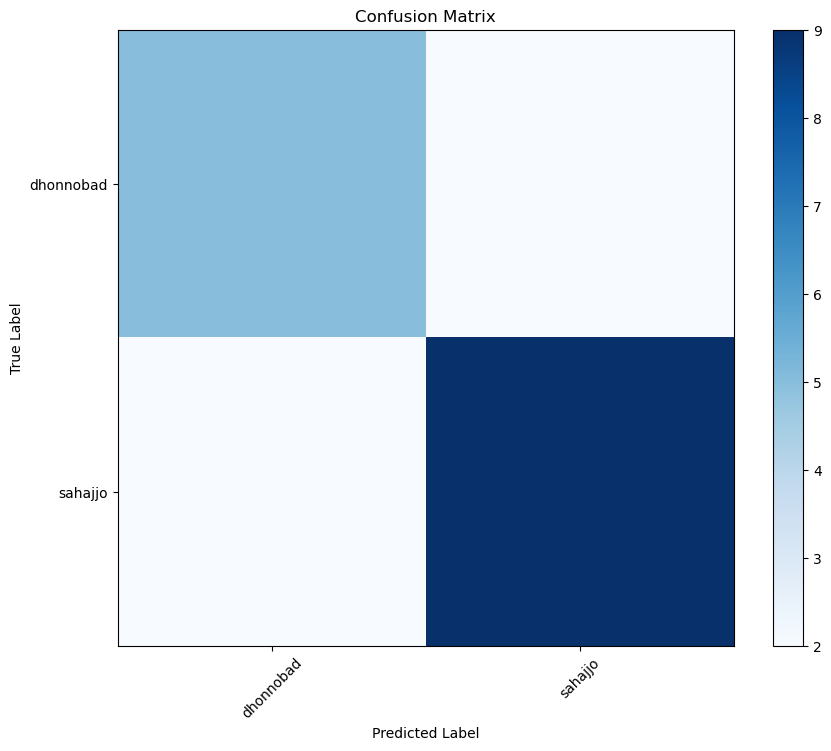

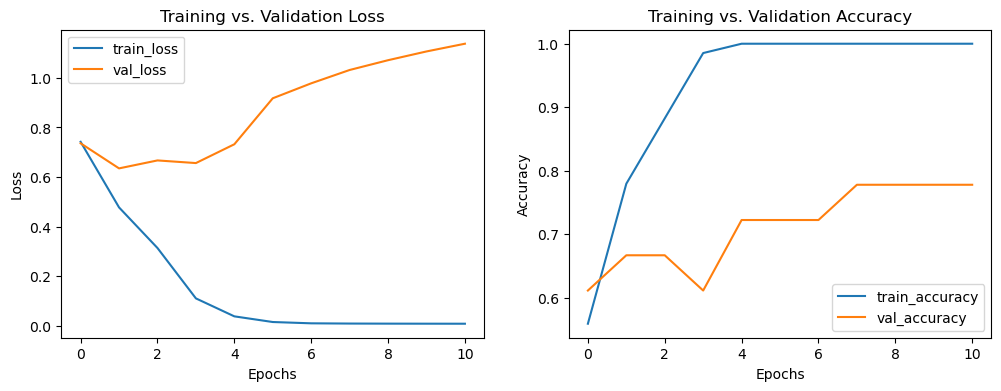

In [10]:

# Custom callback to calculate precision, recall, and F1 score
class MetricsCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        val_predict = np.argmax(self.model.predict(X_val), axis=1)
        val_targ = y_val
        _val_precision = precision_score(val_targ, val_predict, average='macro')
        _val_recall = recall_score(val_targ, val_predict, average='macro')
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        print(f'— val_precision: {_val_precision:.4f} — val_recall: {_val_recall:.4f} — val_f1: {_val_f1:.4f}')

metrics_callback = MetricsCallback()

# Train the model
history = model.fit(X_train, y_train,
                    batch_size=4,
                    epochs=30,
                    validation_data=(X_val, y_val),
                    callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback, reduce_lr_callback, metrics_callback])

# Save the trained model to the specified directory with the specified name
save_dir = os.path.join(os.path.expanduser("~"), "Desktop", "cse499b", "vggish_model")
os.makedirs(save_dir, exist_ok=True)
model.save(os.path.join(save_dir, 'vggish_multimodal.h5'))

# Plot confusion matrix
y_pred = np.argmax(model.predict(X_val), axis=1)
cm = confusion_matrix(y_val, y_pred)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Plot training vs. validation loss and accuracy
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs. Validation Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.legend()

plt.show()


In [11]:
# # Train the model
# model.fit(X_train, y_train,
#           batch_size=8,
#           epochs=30,
#           validation_data=(X_val, y_val),
#           callbacks=[checkpoint_callback, early_stopping_callback, tensorboard_callback, reduce_lr_callback])

# # Save the trained model
# model.save('sign_language_detection_model.h5')